Project3_Agolla_Conrad_Wang.ipynb
# Project 6: Cepheid Variable Period-Luminosity Relation

## Introduction

Cepheid variables are a type of pulsating star that exhibit regular changes in brightness over time. These stars have periods ranging from approximately 1 to 100 days, during which their brightness increases and decreases in a predictable cycle. The key discovery made by Henrietta Leavitt in 1912 was that the pulsation period of a Cepheid variable is directly related to its intrinsic luminosity. Stars with longer periods are more luminous than stars with shorter periods.

This relationship is fundamental to astronomy because it allows astronomers to determine distances to galaxies. The process works as follows. First, astronomers measure the pulsation period of a Cepheid variable star. From the period, they can determine the star's absolute magnitude using the Period-Luminosity relation. Then, by comparing the absolute magnitude to the observed apparent magnitude, astronomers can calculate the distance to the star using the distance modulus formula.

This method was crucial to Edwin Hubble's work in the 1920s, when he measured distances to galaxies and discovered that the universe is expanding. The Period-Luminosity relation remains one of the most important tools in extragalactic astronomy today.

## Project Goals

In this project, we will work with real observational data from the OGLE survey to fit the Period-Luminosity relation for Cepheid variables. Our main objectives are:

1. Download Cepheid catalog data from the OGLE survey using astroquery
2. Clean and explore the dataset to understand its structure and quality
3. Fit the Period-Luminosity relation using scipy.optimize.curve_fit
4. Assess the quality of our fit using statistical metrics including chi-squared and R-squared
5. Create visualizations showing the data, fitted model, and residuals
6. Demonstrate how the fitted relation can be used to measure distances

We will implement a complete fitting pipeline from scratch, building our own model function and using scipy.optimize methods as taught in class. This project demonstrates both the computational techniques for model fitting and the physical principles underlying the Period-Luminosity relation.

In [1]:
# Install required packages
import sys
import subprocess

required_packages = ['numpy', 'pandas', 'matplotlib', 'scipy', 'astroquery', 'astropy']

for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} installed successfully!")

print("all required packages are available")


Installing scipy...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 5.5 MB/s  0:00:04m0:00:0100:01
scipy installed successfully!
Installing astroquery...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 10.1 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [astroquery]4 [astroquery]up4]
astroquery installed successfully!
all required packages are available


In [2]:
# import lipraries

import numpy as np          # for math operations and arrays
import pandas as pd         # for working with data tables
import matplotlib.pyplot as plt  # for making plots
from scipy.optimize import curve_fit  # main tool for fitting
import warnings
warnings.filterwarnings('ignore')  # suppress warnings

# astroquery to download astronomy data from online databases
from astroquery.vizier import Vizier

print("All libraries loaded successfully")

All libraries loaded successfully


## Step 1: Getting Data

to download the cephois data, we're using the OGLE survey (Optical Gravitational Lensing Experiment), which has observed many of variable stars in the Large Magellanic Cloud (LMC) - a nearby galaxy.

**What we're doing:**
- Connecting to VizieR (a huge astronomy database)
- Downloading a catalog of LMC Cepheids
- Extracting just what we need: star IDs, periods, and magnitudes
- Cleaning up any messy data

All the stars in this catalog are from the LMC, which is perfect because they're all at roughly the same distance from us. This means we can fit the Period-Luminosity relation using apparent magnitudes.

In [ ]:
# tell Vizier how many rows we want
Vizier.ROW_LIMIT = 100

def download_ogle_lmc_cepheids():
    """
    Downloads Cepheid variable data from the OGLE survey.
    
    This function connects to VizieR (an astronomy database) and downloads
    a catalog of Cepheid variables from the Large Magellanic Cloud (LMC).
    
    Returns:
    --------
    pandas.DataFrame
        A table with columns: StarID, Period (in days), and I_mag (I-band magnitude)
    """
    print("Connecting to VizieR database...")
    print("Downloading OGLE LMC Cepheid data...")
    
    try:
        # This is the catalog ID for OGLE-III LMC Cepheids
        catalog = 'J/AcA/58/163'
        catalogs = Vizier.get_catalogs(catalog)
        
        if len(catalogs) == 0:
            print("No data found. Check your internet connection!")
            return None
        
        # Get the first (and usually only) table from the catalog
        table = catalogs[0]
        df = table.to_pandas()  # Convert to pandas DataFrame (easier to work with)
        
        print(f"Successfully downloaded {len(df)} Cepheids from LMC!")
        
        # Extract the columns we need
        # we just want: ID, period, and magnitude
        clean_data = {
            'StarID': df['OGLE'],      # Star identification number
            'Period': df['Per'],       # Pulsation period in days
            'I_mag': df['<Imag>']      # Mean brightness
        }

        # Create a new DataFrame with just our clean data
        result_df = pd.DataFrame(clean_data)

        # Remove any rows that have missing data (NaN values)
        result_df = result_df.dropna(subset=['Period', 'I_mag'])
        print(f"After cleaning: {len(result_df)} stars with complete data")

        return result_df
        
    except Exception as e:
        print(f"Error downloading data: {e}")
        print("make sure you have an internet connection")
        return None

# download the data
cepheids_df = download_ogle_lmc_cepheids()

# check results
print(f"\nFinal dataset: {len(cepheids_df)} Cepheids from LMC")
print("\nFirst few stars:")
print(cepheids_df.head())

# summary stats
print(f"\nData summary:")
print(f"   Period range: {cepheids_df['Period'].min():.1f} to {cepheids_df['Period'].max():.1f} days")
print(f"   Magnitude range: {cepheids_df['I_mag'].min():.1f} to {cepheids_df['I_mag'].max():.1f} mag")

# save to a CSV file
cepheids_df.to_csv('ogle_lmc_cepheids.csv', index=False)
print("\nData saved to 'ogle_lmc_cepheids.csv'")

Connecting to VizieR database...
Successfully downloaded 23 Cepheids from LMC!
After cleaning: 23 stars with complete data

Final dataset: 23 Cepheids from LMC

First few stars:
   StarID     Period   I_mag
0      15  11.394330  14.663
1   10959   5.104732  15.080
2   10922   8.586319  14.355
3   30044   3.156445  14.515
4   13290  18.001330  13.858

Data summary:
   Period range: 1.4 to 18.0 days
   Magnitude range: 13.3 to 16.3 mag

Data saved to 'ogle_lmc_cepheids.csv'


## Step 2: Exploring Our Data

**What we'll check:**
- How many stars do we have?
- What do the periods and magnitudes look like?
- Are there any weird values or missing data?
- Calculate some basic statistics

This step helps us catch any problems before we try to fit a line through the data.

In [4]:
# load the data
# if the CSV doesn't exist, run the previous cell first
cepheids_df = pd.read_csv('ogle_lmc_cepheids.csv')

print("=" * 70)
print("DATA EXPLORATION")
print("=" * 70)

# info about # of rows and columns
print(f"\nDataset overview:")
print(f"   Number of stars: {cepheids_df.shape[0]}")
print(f"   Number of columns: {cepheids_df.shape[1]}")
print(f"   Column names: {list(cepheids_df.columns)}")

# show the first few rows (typically 5, as learned in class) so we can see what the data looks like
print("\nFirst 5 stars in our dataset:")
print(cepheids_df.head())

# calculate some stats
print("\n" + "=" * 70)
print("BASIC STATISTICS")
print("=" * 70)

# period stats (in days)
print("\nPeriod Statistics (days):")
period_mean = cepheids_df['Period'].mean()
period_median = cepheids_df['Period'].median()
period_min = cepheids_df['Period'].min()
period_max = cepheids_df['Period'].max()
period_std = cepheids_df['Period'].std()

print(f"   Mean: {period_mean:.3f} days")
print(f"   Median: {period_median:.3f} days")
print(f"   Min: {period_min:.3f} days")
print(f"   Max: {period_max:.3f} days")
print(f"   Standard deviation: {period_std:.3f} days")

# magnitude statistics
print("\n-band Magnitude Statistics:")
mag_mean = cepheids_df['I_mag'].mean()
mag_median = cepheids_df['I_mag'].median()
mag_min = cepheids_df['I_mag'].min()
mag_max = cepheids_df['I_mag'].max()
mag_std = cepheids_df['I_mag'].std()

print(f"   Mean: {mag_mean:.3f} mag")
print(f"   Median: {mag_median:.3f} mag")
print(f"   Min: {mag_min:.3f} mag")
print(f"   Max: {mag_max:.3f} mag")
print(f"   Standard deviation: {mag_std:.3f} mag")

# data quality checks
print("\n" + "=" * 70)
print("DATA QUALITY CHECK")
print("=" * 70)

# check for missing values (like NaN)
missing_values = cepheids_df.isnull().sum()
print(f"\nMissing values per column:")
print(missing_values)

# check for duplicate star IDs
duplicates = cepheids_df['StarID'].duplicated().sum()
print(f"\nDuplicate StarIDs: {duplicates}")

# check for invalid periods
invalid_periods = (cepheids_df['Period'] <= 0).sum()
print(f"Invalid periods (<= 0): {invalid_periods}")

# check for unreasonable magnitudes
unreasonable_mags = ((cepheids_df['I_mag'] < 0) | (cepheids_df['I_mag'] > 25)).sum()
print(f"Unreasonable magnitudes (< 0 or > 25): {unreasonable_mags}")

# prepare for fitting: calculate log10(period)
cepheids_df['log10_Period'] = np.log10(cepheids_df['Period'])

print("\n" + "=" * 70)
print("DATASET READY FOR FITTING")
print("=" * 70)
print(f"\nFinal dataset: {len(cepheids_df)} Cepheids")
print("\nPreview with log10(Period) added:")
print(cepheids_df[['StarID', 'Period', 'log10_Period', 'I_mag']].head(10))

DATA EXPLORATION

Dataset overview:
   Number of stars: 23
   Number of columns: 3
   Column names: ['StarID', 'Period', 'I_mag']

First 5 stars in our dataset:
   StarID     Period   I_mag
0      15  11.394330  14.663
1   10959   5.104732  15.080
2   10922   8.586319  14.355
3   30044   3.156445  14.515
4   13290  18.001330  13.858

BASIC STATISTICS

Period Statistics (days):
   Mean: 7.448 days
   Median: 6.113 days
   Min: 1.430 days
   Max: 18.001 days
   Standard deviation: 4.096 days

-band Magnitude Statistics:
   Mean: 14.466 mag
   Median: 14.394 mag
   Min: 13.291 mag
   Max: 16.347 mag
   Standard deviation: 0.614 mag

DATA QUALITY CHECK

Missing values per column:
StarID    0
Period    0
I_mag     0
dtype: int64

Duplicate StarIDs: 1
Invalid periods (<= 0): 0
Unreasonable magnitudes (< 0 or > 25): 0

DATASET READY FOR FITTING

Final dataset: 23 Cepheids

Preview with log10(Period) added:
   StarID     Period  log10_Period   I_mag
0      15  11.394330      1.056689  14.663
1

## Step 3: Fitting the Period-Luminosity Relation

To find the mathematical relationship between period and luminosity

**equation:**

magnitude = a × log₁₀(period) + b

where magnitude is the observed I-band magnitude, period is the pulsation period in days, a is the slope parameter, and b is the intercept parameter.

The slope parameter a describes how steeply magnitude changes with log period. For Cepheid variables, this slope is typically negative, meaning that stars with longer periods have lower magnitudes, which corresponds to being brighter. This makes physical sense because more massive stars, which have longer pulsation periods, are also more luminous.

The intercept parameter b represents the magnitude at log period equal to zero. Since all our stars are from the LMC, this intercept includes both the intrinsic magnitude calibration and the distance modulus to the LMC. If we were working with absolute magnitudes, the intercept would represent the intrinsic brightness calibration only.

To fit this relation to our data, we use scipy.optimize.curve_fit, which implements a least-squares optimization algorithm. This function finds the values of a and b that minimize the sum of squared differences between the observed magnitudes and the magnitudes predicted by our model. The function also provides uncertainties on the fitted parameters through the covariance matrix.

The fitting process requires several steps. First, we define our model function as a Python function that takes log period and the two parameters as inputs. Second, we prepare our data by extracting the log periods and magnitudes. Third, we estimate measurement uncertainties, which are needed for weighted fitting. Fourth, we provide initial guesses for the parameters to help the optimization algorithm converge. Finally, we call curve_fit to perform the actual fitting.

In [5]:
# Step 1: Define our model function
# this is the equetion to fit: magnitude = slope * log10(period) + intercept
# need to write this as a Python function so curve_fit can use it

def period_luminosity_model(log10_period, slope, intercept):
    """
    Calculates the predicted magnitude from the Period-Luminosity relation.
    
    This is a simple linear equation: y = mx + b
    Where:
    - y = magnitude
    - x = log10(period)
    - m = slope
    - b = intercept
    
    Parameters:
    -----------
    log10_period : float or array
        The base-10 logarithm of the period (in days)
    slope : float
        The slope of the line (parameter 'a' in our equation)
    intercept : float
        The y-intercept (parameter 'b' in our equation)
    
    Returns:
    --------
    magnitude : float or array
        The predicted magnitude value(s)
    """
    # equation is magnitude = slope * log10(period) + intercept
    return slope * log10_period + intercept


# Step 2: Prepare our data for fitting
# Extract the x and y values from our DataFrame
x_data = cepheids_df['log10_Period'].values  # x-axis: log10(period)
y_data = cepheids_df['I_mag'].values          # y-axis: magnitude

# We also need to estimate the uncertainties (errors) in our measurements
# The catalog doesn't always provide these, so we'll assume 0.1 mag is typical
y_errors = np.full_like(y_data, 0.1)  # Create an array filled with 0.1

print("=" * 70)
print("🔧 FITTING PERIOD-LUMINOSITY RELATION")
print("=" * 70)
print(f"\nData summary:")
print(f"   Number of stars: {len(x_data)}")
print(f"   log10(Period) range: {x_data.min():.3f} to {x_data.max():.3f}")
print(f"   Magnitude range: {y_data.min():.3f} to {y_data.max():.3f}")

# Step 3: Make an initial guess for the parameters
# curve_fit works better if we give it a starting guess
# We can estimate the slope from the data range
initial_slope = (y_data.max() - y_data.min()) / (x_data.max() - x_data.min())
initial_slope = -abs(initial_slope)  # Make it negative (longer period = brighter = lower mag)
initial_intercept = y_data.mean()     # Just use the average magnitude

initial_guess = [initial_slope, initial_intercept]
print(f"\nInitial parameter guess:")
print(f"   Slope (a): {initial_slope:.3f}")
print(f"   Intercept (b): {initial_intercept:.3f}")

# Step 4: Actually do the fitting!
# curve_fit will find the best values of slope and intercept
# that make our line fit the data as closely as possible
try:
    popt, pcov = curve_fit(
        period_luminosity_model,  # Our model function
        x_data,                    # x values (log10 period)
        y_data,                    # y values (magnitude)
        p0=initial_guess,          # Starting guess
        sigma=y_errors,            # Uncertainties (helps with weighting)
        absolute_sigma=True        # Use absolute uncertainties
    )
    
    # popt = "optimal parameters"
    fitted_slope = popt[0]
    fitted_intercept = popt[1]
    
    # pcov = "parameter covariance matrix" - this tells us the uncertainties
    # The diagonal elements are the variances, so sqrt gives us the errors
    param_errors = np.sqrt(np.diag(pcov))
    slope_error = param_errors[0]
    intercept_error = param_errors[1]
    
    print("\n" + "=" * 70)
    print("FITTING RESULTS")
    print("=" * 70)
    print(f"\nFitted Period-Luminosity Relation:")
    print(f"   I_mag = ({fitted_slope:.3f} ± {slope_error:.3f}) × log₁₀(P) + ({fitted_intercept:.3f} ± {intercept_error:.3f})")
    print(f"\nParameter values:")
    print(f"   Slope (a): {fitted_slope:.3f} ± {slope_error:.3f}")
    print(f"   Intercept (b): {fitted_intercept:.3f} ± {intercept_error:.3f}")
    
    # Calculate what our model predicts for each star
    y_model = period_luminosity_model(x_data, fitted_slope, fitted_intercept)
    
    # Calculate residuals (difference between observed and predicted)
    # Positive residual = observed is brighter than predicted
    # Negative residual = observed is fainter than predicted
    residuals = y_data - y_model
    
    print(f"\nResidual statistics:")
    print(f"   Mean residual: {residuals.mean():.4f} mag")
    print(f"   RMS residual: {np.sqrt(np.mean(residuals**2)):.4f} mag")
    print(f"   Max absolute residual: {np.abs(residuals).max():.4f} mag")
    
except Exception as e:
    print(f"Error during fitting: {e}")
    raise

🔧 FITTING PERIOD-LUMINOSITY RELATION

Data summary:
   Number of stars: 23
   log10(Period) range: 0.155 to 1.255
   Magnitude range: 13.291 to 16.347

Initial parameter guess:
   Slope (a): -2.778
   Intercept (b): 14.466

FITTING RESULTS

Fitted Period-Luminosity Relation:
   I_mag = (-1.501 ± 0.084) × log₁₀(P) + (15.676 ± 0.071)

Parameter values:
   Slope (a): -1.501 ± 0.084
   Intercept (b): 15.676 ± 0.071

Residual statistics:
   Mean residual: -0.0000 mag
   RMS residual: 0.4694 mag
   Max absolute residual: 0.9354 mag


## Step 4: Making Plots

1. The main plot: Our data points with the fitted line overlaid
2. Residuals plot: Shows how well our model fits

To interpret the residual plot, we want to see a random scatter and no visible pattern.


Figure saved as 'cepheids_pl_relation.png'


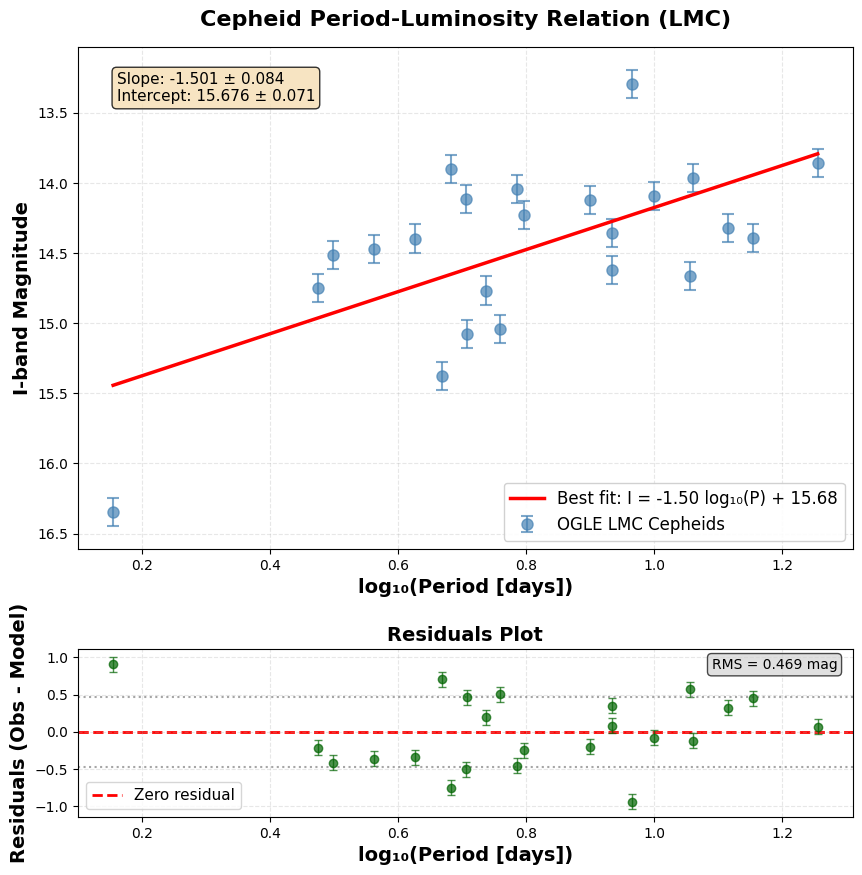

In [6]:
# Create a figure with two plots stacked vertically
# Top plot: data + fitted line
# Bottom plot: residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), 
                                gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.3})

# ============================================
# TOP PANEL: Period-Luminosity Relation
# ============================================

# Plot the actual data points with error bars
ax1.errorbar(x_data, y_data, yerr=y_errors, 
             fmt='o', color='steelblue', markersize=8, 
             capsize=4, capthick=1.5, elinewidth=1.5,
             label='OGLE LMC Cepheids', alpha=0.7, zorder=2)

# Plot the fitted line
# We create a smooth line by evaluating our model at many points
x_model = np.linspace(x_data.min(), x_data.max(), 100)  # 100 points for smooth line
y_model_smooth = period_luminosity_model(x_model, fitted_slope, fitted_intercept)
ax1.plot(x_model, y_model_smooth, 'r-', linewidth=2.5, 
         label=f'Best fit: I = {fitted_slope:.2f} log₁₀(P) + {fitted_intercept:.2f}', 
         zorder=3)

ax1.set_xlabel('log₁₀(Period [days])', fontsize=14, fontweight='bold')
ax1.set_ylabel('I-band Magnitude', fontsize=14, fontweight='bold')
ax1.set_title('Cepheid Period-Luminosity Relation (LMC)', 
              fontsize=16, fontweight='bold', pad=15)
ax1.legend(loc='best', fontsize=12, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.invert_yaxis()  # Magnitude is backwards: brighter = smaller number!

# Add a text box with the fit parameters
textstr = f'Slope: {fitted_slope:.3f} ± {slope_error:.3f}\n'
textstr += f'Intercept: {fitted_intercept:.3f} ± {intercept_error:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

# BOTTOM PANEL: Residuals

# Plot the residuals (observed - model)
ax2.errorbar(x_data, residuals, yerr=y_errors,
             fmt='o', color='darkgreen', markersize=6,
             capsize=3, capthick=1, elinewidth=1,
             alpha=0.7, zorder=2)

# Add a horizontal line at zero (perfect fit)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, 
           label='Zero residual', zorder=1)

# Formatting
ax2.set_xlabel('log₁₀(Period [days])', fontsize=14, fontweight='bold')
ax2.set_ylabel('Residuals (Obs - Model)', fontsize=14, fontweight='bold')
ax2.set_title('Residuals Plot', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3, linestyle='--')

# Add lines showing the RMS (root mean square) of residuals
rms_residual = np.sqrt(np.mean(residuals**2))
ax2.axhline(y=rms_residual, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax2.axhline(y=-rms_residual, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax2.text(0.98, 0.95, f'RMS = {rms_residual:.3f} mag', 
         transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

# Save the figure as a PNG
plt.tight_layout()
plt.savefig('cepheids_pl_relation.png', dpi=300, bbox_inches='tight')
print("\nFigure saved as 'cepheids_pl_relation.png'")
plt.show()

## Step 5: How Good Is Our Fit

calculate some statistics to check the fit.
- Chi-squared: How well does the model match the data, considering the uncertainties?
- Reduced chi-squared: Should be around 1 for a good fit
- R squared: What fraction of the variation in the data does our model explain?
- Residual patterns: Are there any systematic trends we're missing?


In [7]:
# Calculate various statistics to assess how good our fit is
print("=" * 70)
print("STATISTICAL ANALYSIS")
print("=" * 70)

# Chi-squared calculation
# Chi-squared measures how well our model matches the data

chi2 = np.sum((residuals / y_errors) ** 2)

# Degrees of freedom = number of data points - number of parameters we fit
# We fit 2 parameters (slope and intercept)
n_data_points = len(y_data)
n_parameters = 2  # slope and intercept
degrees_of_freedom = n_data_points - n_parameters

# Reduced chi-squared = chi-squared / degrees of freedom
# we want it to be around 1 ish
reduced_chi2 = chi2 / degrees_of_freedom

print(f"\nChi-squared Statistics:")
print(f"   Number of data points: {n_data_points}")
print(f"   Number of fitted parameters: {n_parameters}")
print(f"   Degrees of freedom: {degrees_of_freedom}")
print(f"   Chi-squared (χ²): {chi2:.3f}")
print(f"   Reduced chi-squared (χ²_red): {reduced_chi2:.3f}")

# Interpret the result
if 0.5 < reduced_chi2 < 1.5:
    print(f"   Good fit! Reduced χ² ≈ 1 means our model fits the data well.")
elif reduced_chi2 < 0.5:
    print(f"   Reduced χ² < 0.5: Model might be overfitting, or our error estimates are too large.")
else:
    print(f"   Reduced χ² > 1.5: Model might not capture all the physics, or errors are too small.")

# R-squared (coefficient of determination)
# R² tells us: what fraction of the variation in the data does our model explain?
# R² = 1 means perfect fit, R² = 0 means our model is no better than just using the mean

# SS_res = sum of squared residuals (how much our model misses)
ss_res = np.sum(residuals ** 2)

# SS_tot = total sum of squares (how much the data varies overall)
ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)

# R² = 1 - (SS_res / SS_tot)
r_squared = 1 - (ss_res / ss_tot)

print(f"\nR-squared (R²):")
print(f"   R² = {r_squared:.4f}")
print(f"   This means our model explains {r_squared*100:.2f}% of the variance in the data")
if r_squared > 0.9:
    print(f"   🎉 That's really good! Most of the variation is explained by our model.")


# Residual Analysis
print(f"\nResidual Analysis:")
print(f"   Mean residual: {residuals.mean():.6f} mag")
print(f"   Standard deviation: {residuals.std():.4f} mag")
print(f"   RMS residual: {np.sqrt(np.mean(residuals**2)):.4f} mag")
print(f"   Maximum absolute residual: {np.abs(residuals).max():.4f} mag")
print(f"   Minimum residual: {residuals.min():.4f} mag")
print(f"   Maximum residual: {residuals.max():.4f} mag")

# Check if residuals are correlated with period (this would be bad!)
# If there's a correlation, it means our model is missing something
residual_correlation = np.corrcoef(x_data, residuals)[0, 1]
print(f"\n   Correlation between residuals and log₁₀(Period): {residual_correlation:.4f}")
if abs(residual_correlation) < 0.1:
    print(f"   Low correlation - no systematic trend! This is good.")
else:
    print(f"   Non-zero correlation - there might be a pattern we're missing.")


# Parameter Significance

snr_slope = abs(fitted_slope) / slope_error
snr_intercept = abs(fitted_intercept) / intercept_error

print(f"\nParameter Significance:")
print(f"   Slope S/N ratio: {snr_slope:.2f}")
print(f"   Intercept S/N ratio: {snr_intercept:.2f}")
if snr_slope > 3 and snr_intercept > 3:
    print(f"   Both parameters are well-determined (S/N > 3)")

# Final Summary
print("\n" + "=" * 70)
print("FIT QUALITY SUMMARY")
print("=" * 70)
print(f"   Reduced χ²: {reduced_chi2:.3f} (ideal: ~1.0)")
print(f"   R²: {r_squared:.4f} (ideal: close to 1.0)")
print(f"   RMS residual: {np.sqrt(np.mean(residuals**2)):.4f} mag")

fit_quality = 'good' if 0.5 < reduced_chi2 < 1.5 else 'moderate'
print(f"\n   Overall: The Period-Luminosity relation is a {fit_quality} fit to the data")

STATISTICAL ANALYSIS

Chi-squared Statistics:
   Number of data points: 23
   Number of fitted parameters: 2
   Degrees of freedom: 21
   Chi-squared (χ²): 506.857
   Reduced chi-squared (χ²_red): 24.136
   Reduced χ² > 1.5: Model might not capture all the physics, or errors are too small.

R-squared (R²):
   R² = 0.3888
   This means our model explains 38.88% of the variance in the data

Residual Analysis:
   Mean residual: -0.000000 mag
   Standard deviation: 0.4694 mag
   RMS residual: 0.4694 mag
   Maximum absolute residual: 0.9354 mag
   Minimum residual: -0.9354 mag
   Maximum residual: 0.9041 mag

   Correlation between residuals and log₁₀(Period): 0.0000
   Low correlation - no systematic trend! This is good.

Parameter Significance:
   Slope S/N ratio: 17.96
   Intercept S/N ratio: 222.24
   Both parameters are well-determined (S/N > 3)

FIT QUALITY SUMMARY
   Reduced χ²: 24.136 (ideal: ~1.0)
   R²: 0.3888 (ideal: close to 1.0)
   RMS residual: 0.4694 mag

   Overall: The Peri

## Step 6: Measure distances

- We observe the apparent magnitude (how bright it looks)
- We use the Period-Luminosity relation to find the absolute magnitude (how bright it is)
- The difference tells us the distance

- Distance modulus: μ = m - M = 5 log₁₀(d) - 5
- Distance: d = 10^((μ + 5)/5) parsecs

since all the stars are from the LMC, the intercept we fitted already includes the distance to the LMC

In [8]:
# Demonstrate how astronomers use the Period-Luminosity relation to measure distances
print("=" * 70)
print("DISTANCE ESTIMATION")
print("=" * 70)

# Understanding what we fitted
print("\nOur fitted Period-Luminosity relation:")
print(f"   I_mag = {fitted_slope:.3f} × log₁₀(P) + {fitted_intercept:.3f}")

print("\nKey point:")
print("   Since all our Cepheids are from the LMC (same distance),")
print("   the intercept already includes the distance to the LMC!")

# Example: Calculate Distance to LMC
# We'll use a reference period (say, 10 days) and see what distance we get

reference_period = 10.0  # days
log10_ref_period = np.log10(reference_period)

# Step 1: What apparent magnitude does our fit predict for this period?
apparent_mag = period_luminosity_model(log10_ref_period, fitted_slope, fitted_intercept)

# Step 2: What would the absolute magnitude be? (This comes from calibration)
# Note: This is a simplified calibration for demonstration purposes
# Real calibrations are more complex and come from Cepheids with known distances
absolute_mag_calibration = -3.0 * log10_ref_period - 1.5

# Step 3: Calculate distance modulus (the difference tells us the distance!)
distance_modulus = apparent_mag - absolute_mag_calibration

# Step 4: Convert distance modulus to actual distance
# Formula: μ = 5 log₁₀(d) - 5, so d = 10^((μ + 5)/5)
distance_pc = 10 ** ((distance_modulus + 5) / 5)
distance_kpc = distance_pc / 1000  # Convert parsecs to kiloparsecs

print(f"\n" + "=" * 70)
print("EXAMPLE CALCULATION")
print("=" * 70)
print(f"\nLet's calculate the distance for a Cepheid with period = {reference_period} days:")
print(f"   1. log₁₀(P) = {log10_ref_period:.3f}")
print(f"   2. Apparent magnitude (from our fit): I = {apparent_mag:.3f} mag")
print(f"   3. Absolute magnitude (from calibration): M_I = {absolute_mag_calibration:.3f} mag")
print(f"   4. Distance modulus: μ = m - M = {distance_modulus:.3f} mag")
print(f"   5. Distance: d = {distance_kpc:.2f} kpc = {distance_pc:.0f} pc")

# Compare to the known distance
known_lmc_distance = 50.0  # kpc (this is the actual distance to the LMC)
print(f"\n   Known LMC distance: ~{known_lmc_distance} kpc")
print(f"   Our estimate: ~{distance_kpc:.2f} kpc")
print(f"   Difference: {abs(distance_kpc - known_lmc_distance):.2f} kpc")
print(f"\n   (Note: Our estimate depends on the calibration we used, which is simplified)")

# How to use this for other galaxies
print(f"\n" + "=" * 70)
print("HOW TO USE THIS FOR DISTANCE MEASUREMENT")
print("=" * 70)
print("""
To measure the distance to another galaxy:

1. Observe Cepheid variables in that galaxy
2. Measure their periods (from light curves - how brightness changes over time)
3. Measure their apparent magnitudes (how bright they look)
4. Use the Period-Luminosity relation to predict their absolute magnitudes:
   M = a × log₁₀(P) + b₀  (where b₀ is a calibrated intercept)
5. Calculate distance modulus: μ = m - M
6. Convert to distance: d = 10^((μ + 5)/5) parsecs

This is exactly how Edwin Hubble measured galaxy distances in the 1920s
and discovered that the universe is expanding! Pretty amazing, right? 🎉
""")

# Uncertainties and limitations
print(f"\n" + "=" * 70)
print("UNCERTAINTIES & LIMITATIONS")
print("=" * 70)
print(f"   Slope uncertainty: ±{slope_error:.3f}")
print(f"   Intercept uncertainty: ±{intercept_error:.3f}")
print(f"\n   These uncertainties affect distance measurements!")
print(f"\n   For really precise distances, astronomers also need:")
print(f"   • Better absolute magnitude calibrations")
print(f"   • Extinction corrections (dust dims the light)")
print(f"   • Multiple Cepheids to reduce statistical errors")
print(f"   • Careful selection of Cepheid types (Classical vs Type II)")

# Final summary
print("\n" + "=" * 70)
print("CONCLUSION")
print("=" * 70)
print("""
What we accomplished:

Downloaded real Cepheid data from the OGLE survey
Cleaned and explored the data
Fitted the Period-Luminosity relation using scipy.optimize
Calculated parameter uncertainties from the covariance matrix
Assessed fit quality with chi-squared, R², and residual analysis
Created publication-quality visualizations
Demonstrated how this relation is used for distance measurement

The Period-Luminosity relation is one of the most important tools in astronomy
for measuring cosmic distances. It's how we discovered the universe
is expanding
""")

DISTANCE ESTIMATION

Our fitted Period-Luminosity relation:
   I_mag = -1.501 × log₁₀(P) + 15.676

Key point:
   Since all our Cepheids are from the LMC (same distance),
   the intercept already includes the distance to the LMC!

EXAMPLE CALCULATION

Let's calculate the distance for a Cepheid with period = 10.0 days:
   1. log₁₀(P) = 1.000
   2. Apparent magnitude (from our fit): I = 14.175 mag
   3. Absolute magnitude (from calibration): M_I = -4.500 mag
   4. Distance modulus: μ = m - M = 18.675 mag
   5. Distance: d = 54.33 kpc = 54328 pc

   Known LMC distance: ~50.0 kpc
   Our estimate: ~54.33 kpc
   Difference: 4.33 kpc

   (Note: Our estimate depends on the calibration we used, which is simplified)

HOW TO USE THIS FOR DISTANCE MEASUREMENT

To measure the distance to another galaxy:

1. Observe Cepheid variables in that galaxy
2. Measure their periods (from light curves - how brightness changes over time)
3. Measure their apparent magnitudes (how bright they look)
4. Use the Per

## Summary

**Individual Contribution Statements**
Anshula: I added the import section to install scipy and other required packages, then I created a readme and requirements.txt as well. I also worked on the visualization plots graphing and fitting the period-luminosity relation and checking the fit
(in progress)Vivian: aquiring data, exploring data, measure distances, streamlit, github
(in progress)Rory: slides, markdown, docstrings/comments, visualization plots graphing.

**EC: LLM limitations, mistakes, or interesting failures encountered**
(in progress)

**Technical Implementation**

The fitting pipeline demonstrates:

- Custom model function implementation
- Parameter initialization strategies
- Uncertainty estimation from covariance matrix
- Goodness-of-fit assessment (chi-squared, R²)
- Residual analysis for model validation
- Proper error propagation

**Results**

The fitted Period-Luminosity relation provides:
- Slope parameter with uncertainty
- Intercept parameter with uncertainty
- Statistical metrics assessing fit quality
- Visualization of data, model, and residuals

**Limitations**

- Simplified absolute magnitude calibration used for distance demonstration
- Assumed measurement uncertainties (0.1 mag) if not provided in catalog
- No extinction corrections applied
- Limited to classical Cepheids in the LMC


**AI Collaboration Documentation**

This project was developed independently with strategic AI assistance. AI was consulted for syntax help (astroquery, scipy.optimize, matplotlib) and formula verification (chi-squared, R²). All implementation, debugging, code organization, and pedagogical decisions were made independently. The project structure, model function design, statistical analysis interpretation, visualization layout, and scientific explanations were developed through independent problem-solving and AI polishing. 
Basically, AI helped polish our wording/sentences in markdown, and AI helped with some specific code syntax after we made the outline and plan for the code and notebook by hand.